![image.png](plots/dim_red_intro.png)

En los problemas de machine learning es habitual trabajar con decenas, cientos o incluso miles de variables simultaneamente a la hora de hacer predicciones. Cuantas más variables tengamos, mejor, ¿no? Más información tendremos disponible... __Cuidado, porque eso no tiene porque ser cierto__. Puede que muchas de las variables del conjunto nos den información redundante (por ejemplo, código postal y ciudad), o puede que la información que nos están dando simplemente no sea relevante para nuestro problema (por ejemplo, el color de ojos para predecir la morosidad). Todas esas variables extra lo único que hacen es ocupar memoria en el ordenador, ralentizar la ejecución de los algoritmos y, en última instancia, producir predicciones que estén sobre ajustadas.

Esto es lo que se conoce como __la maldición de la dimensionalidad__, y la forma de luchar contra este problema es... reduciendo la dimensión. Existen varias formas de reducir la dimensión de un conjunto de datos. Aquí nos centraremos en dos alternativas:

* Selección de variables

* Proyecciones

# Selección de variables con filtering
___

La idea intuitiva detrás de la selección de variables es sencilla: intentar seleccionar las variables más importantes de nuestro conjunto, y descartar las demás. Aquí nos centraremos en la selección con filtering:

* Filtering: Hacemos un ranking de importancia de las variables y filtramos para quedarnos con las primeras del ranking. Después ejecutamos nuestro modelo con este subconjunto de variables.

## BostonHousing
Para ello, veamos un ejemplo. Nos descargaremos el conjunto de datos de __Boston Housing__, que contiene información sobre el precio mediano de la vivienda en diferentes barrios de la ciudad de boston, así como una serie de variables socio-económicas de esos barrios. El objetivo de este problema es predecir el precio mediano de la vivienda en un barrio dadas el resto de variables. Empecemos descargando los datos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_boston

%matplotlib inline

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

In [2]:
boston = load_boston()
X_boston = pd.DataFrame(boston.data, columns = boston.feature_names)

y_boston = boston.target

In [3]:
X_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Veamos un histograma de la variable respuesta.

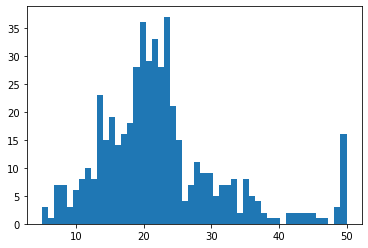

In [4]:
p = plt.hist(y_boston, bins=50)

### <font color='D12828'> Ejercicio: </font>
1. Obtén un scatterplot entre la variable respuesta y cada una de las variables predictoras. Pista: Usa `plt.subplot` y un bucle `for`.

In [36]:
# Ejercicio

plt.figure(figsize=(16, 13))

for idx, var in enumerate(X_boston.columns):
    plt.subplot(4, 4, idx+1)
    plt.scatter(X_boston[var], y_boston)
    plt.title(var)

### <font color='D12828'> Ejercicio: </font>
1. Divide el conjunto de datos en `X_boston_train`, `y_boston_train`, `X_boston_test`, `y_boston_test` usando un 80% de los datos para training. Pista: `from sklearn.model_selection import train_test_split`

2. Estandariza el conjunto de datos de train y de test y llámalos `X_boston_train_s` y `X_boston_test_s`. Pista: `from sklearn.preprocessing import StandardScaler`

In [6]:
# Ejercicio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(X_boston, y_boston, train_size=0.8, random_state=42)

scaler = StandardScaler()

X_boston_train_s = scaler.fit_transform(X_boston_train)
X_boston_test_s = scaler.transform(X_boston_test)

Entrenemos un modelo con todas las variables para tomarlo de referencia. Para ello usaremos una SVM de regresión, ya que la variable respuesta es cuantitativa.

In [7]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import os

num_cores = os.cpu_count()

# Entrenar modelo
svr_model = SVR(kernel='linear')
svr_model.fit(X_boston_train_s, y_boston_train)

# Predecir en el conjunto de test
y_test_pred = svr_model.predict(X_boston_test_s)

# Error 
error = mean_squared_error(y_boston_test, y_test_pred)
print(f'Error cuadrático medio: {error}')

Error cuadrático medio: 28.91852267161813


## `SelectKBest` en regresión

Esta función forma parte del paquete de sklearn. Su funcionamiento es sencillo: __selecciona las k mejores variables__ en función del criterio que nosotros le indiquemos. Lo habitual en problemas de regresión es utilizar como criterio el `f_regression`, que está muy relacionado con la correlación entre las variables predictoras y la respuesta, aunque hay otras alternativas, como `mutual_info_regression`, especialmente recomendada si creemos que la relación entre las variables y la respuesta puede ser no lineal. Podeis consultar toda la información de esta función [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

![image.png](plots/f_mi.png)

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k="all")
selector.fit(X_boston_train_s, y_boston_train)

SelectKBest(k='all', score_func=<function f_regression at 0x000002190151F550>)

Las métricas de cada variable se almacenan en `selector.scores_`. Representemoslas gráficamente

<BarContainer object of 13 artists>

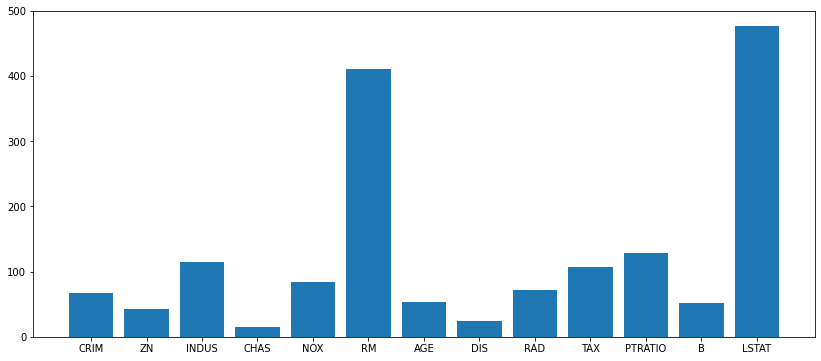

In [9]:
plt.figure(figsize=(14, 6))
plt.bar(boston.feature_names, selector.scores_)

Podemos ver que las variables más importantes son `LSTAT` y `RM`. Así que seleccionaremos estas dos variables y construiremos un nuevo modelo solo con ellas. Esto reducirá la dimensión desde las 13 variables iniciales a 2.

In [10]:
# Seleccionar variables en train
selector = SelectKBest(f_regression, k=2)
X_train_reduced = selector.fit_transform(X_boston_train_s, y_boston_train)

# Seleccionar variables en test
X_test_reduced = selector.transform(X_boston_test_s)

svr_model.fit(X_train_reduced, y_boston_train)

# Predecir en el conjunto de test
y_test_pred = svr_model.predict(X_test_reduced)

# Error 
error = mean_squared_error(y_boston_test, y_test_pred)
print(f'Error cuadrático medio: {error}')

Error cuadrático medio: 33.280592005672716


### <font color='D12828'> Ejercicio: </font>
1. Construye una SVM utilizando las 4 mejores variables de acuerdo al criterio de `mutual_info_regression`
2. Obtén el valor del error cuadrático medio en el conjunto de test

In [11]:
# Ejercicio

from sklearn.feature_selection import mutual_info_regression

# Seleccionar variables en train
selector = SelectKBest(mutual_info_regression, k=4)
X_train_reduced = selector.fit_transform(X_boston_train_s, y_boston_train)

# Seleccionar variables en test
X_test_reduced = selector.transform(X_boston_test_s)

svr_model.fit(X_train_reduced, y_boston_train)

# Predecir en el conjunto de test
y_test_pred = svr_model.predict(selector.transform(X_boston_test_s))

# Error 
error = mean_squared_error(y_boston_test, y_test_pred)
print(f'Error cuadrático medio: {error}')

Error cuadrático medio: 28.561871265658876


### <font color='D12828'> Ejercicio: </font>

1. Construye un pipeline que:
  1. Estandarice los datos
  2. Llame a SelectKBest usando el criterio de f_regression
  3. Construya una SVM
2. Usa la función de `GridSearchCV` para optimizar el número de variables seleccionadas de tu pipeline. Pista: `from sklearn.pipeline import Pipeline`, `from sklearn.model_selection import GridSearchCV`

In [12]:
# Ejercicio

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svr_kbest_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('selector', SelectKBest(f_regression)),
    ('svr', SVR(kernel='linear'))
])

param_grid = [{'selector__k':np.arange(1, 14).tolist()}]

grid_search = GridSearchCV(svr_kbest_pipe, 
                           param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           n_jobs=num_cores - 1,
                           verbose=1)

grid_search.fit(X_boston_train, y_boston_train)

final_model = grid_search.best_estimator_

print(final_model)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
Pipeline(steps=[('scale', StandardScaler()),
                ('selector',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x000002190151F550>)),
                ('svr', SVR(kernel='linear'))])


In [13]:
y_test_pred = final_model.predict(X_boston_test)

error = mean_squared_error(y_boston_test, y_test_pred)

print(f'Error cuadrático medio: {error}')

Error cuadrático medio: 28.43351537816765


## Breast cancer wisconsin

El conjunto de datos de Breast cancer wisconsin está formado por 569 observaciones de pacientes con un tumor, en los cuales se midieron diferentes aspectos de la forma y tamaño del tumor, que conforman 30 variables numéricas. La variable respuesta es categórica, e indica si el tumor es benigno o maligno. El objetivo es predecir el tipo de tumor usando las variables del conjunto de datos. Empecemos observando descargando los datos y observando si las dos categorías están balanceadas:

<BarContainer object of 2 artists>

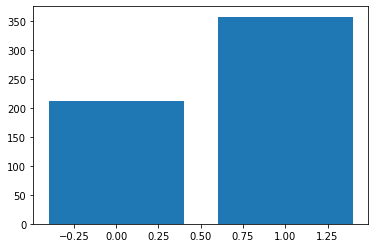

In [14]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()

X_bc, y_bc = bc.data, bc.target

value, count = np.unique(y_bc, return_counts=True)
plt.bar(value, count)

## `SelectKBest` en clasificación

Hemos visto cómo hacer una selección de variables si trabajamos en un problema de regresión, en el que la variable respuesta sea cuantitativa. También podemos hacer el mismo proceso en problemas de clasificación, utilizándo métricas especiales para clasificación. Se usan especialmente las métricas de `f_classif` y de `mutual_info_classif`. Para variar de las SVM, utilizaremos el algoritmo de los K vecinos más próximos `KNeighborsClassifier` en este ejemplo. 


In [15]:
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc)

scaler = StandardScaler()
X_bc_train_s = scaler.fit_transform(X_bc_train)
X_bc_test_s = scaler.fit_transform(X_bc_test)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Entrenar modelo
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_bc_train_s, y_bc_train)

# Predecir en el conjunto de test
y_test_pred = knn.predict(X_bc_test_s)

# Error 
error = accuracy_score(y_bc_test, y_test_pred)
print(f'Accuracy: {error}')

Accuracy: 0.9736842105263158


### <font color='D12828'> Ejercicio: </font>
1. Usa `SelectKBest` y representa gráficamente la importancia de las variables de acuerdo al test `f_classif`
2. Construye una SVM con el número de variables que consideres óptimo en base al gráfico

<BarContainer object of 30 artists>

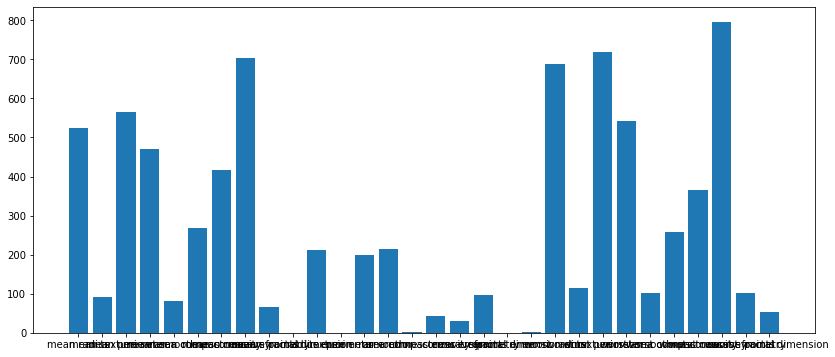

In [17]:
# Ejercicio

from sklearn.feature_selection import f_classif, mutual_info_classif

selector = SelectKBest(f_classif, k="all")
selector.fit(X_bc_train_s, y_bc_train)

plt.figure(figsize=(14, 6))
plt.bar(bc.feature_names, selector.scores_)

In [18]:
# Ejercicio (parte 2)

# Seleccionar variables en train
selector = SelectKBest(f_classif, k=6)
X_train_reduced = selector.fit_transform(X_bc_train_s, y_bc_train)

# Seleccionar variables en test
X_test_reduced = selector.transform(X_bc_test_s)

knn.fit(X_train_reduced, y_bc_train)

# Predecir en el conjunto de test
y_test_pred = knn.predict(X_test_reduced)

# Error 
error = accuracy_score(y_bc_test, y_test_pred)
print(f'Accuracy: {error}')

Accuracy: 0.9473684210526315


# Análisis de componentes principales (PCA)
___

El PCA es la técnica de reducción de la dimensión más utilizada en el mundo. La idea básica detrás del PCA consiste en utilizar las variables originales para __construir unas nuevas variables__, de forma que estas nuevas variables, llamadas componentes principales, expliquen la __mayor cantidad de información__ posible pero sean __ortogonales__ entre sí. Al ser ortogonales entre si, no comparten información por lo que con un número pequeño de componentes principales, se puede explicar la gran mayoría de la información del conjunto de datos original.

Matemáticamene, buscamos encontrar una matriz $P$ tal que $XP=T$, donde $X$ es la matriz con las variables originales, y $T$ es la matriz con las nuevas variables. Veamos un ejemplo con el conjunto de datos de iris. Empecemos sin reducir dimensión, calculando 4 componentes.

In [19]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

iris = load_iris()
X_iris, y_iris = iris.data, iris.target

In [20]:
pca_iris = PCA(n_components=4)

T_iris = pca_iris.fit_transform(X_iris)  # scores
P_iris = pca_iris.components_.T          # loadings

P_iris = pd.DataFrame(P_iris, index=iris.feature_names, columns=['PC1', 'PC2', 'PC3', 'PC4'])
P_iris

,PC1,PC2,PC3,PC4
sepal length (cm),0.361387,0.656589,-0.582030,-0.315487
sepal width (cm),-0.084523,0.730161,0.597911,0.319723
petal length (cm),0.856671,-0.173373,0.076236,0.479839
petal width (cm),0.358289,-0.075481,0.545831,-0.753657


Cada componente principal no es más que un vector apuntando en la dirección de la nueva variable. Como dos vectores con signo opuesto están en el mismo eje aunque tengan direcciones opuestas, __el signo de las componentes principales no es estable__, aunque el valor de los coeficientes sí lo sea. Además, las componentes pueden ser interpretadas (en función de nuestro conocimiento previo de las variables originales). Por ejemplo, 

* La segunda componente, PC2 tiene valores grandes para _sepal length_ y _sepal width_, por lo que es una variable que agrupa la información acerca de la forma del sépalo. A mayor sepalo, mayor será PC2.
* La tercera componente, PC3 tiene un peso negativo para _sepal length_, y positivo para _sepal_width_ y _petal_width_. Esta variable tendrá valores grandes si el petalo y el sépalo son anchos, y el sépalo no es muy largo.

## Comprobación matricial 

Para hacer PCA es necesario trabajar con los datos centrados. Usando sklearn, el algoritmo los centra automáticamente. Hemos dicho que $XP=T$. Veamos si esto es cierto:

In [21]:
# Centramos los datos
X_s = X_iris - np.mean(X_iris, axis=0)

# Visualizamos la primera fila de la matriz centrada
print(f'Xs: {X_s[0,]}')

Xs: [-0.74333333  0.44266667 -2.358      -0.99933333]


In [22]:
# Calculamos el producto de XP
print(f'T: {T_iris[0,]}\n')
print(f'XP={np.dot(X_s, P_iris)[0,:]}')


T: [-2.68412563e+00  3.19397247e-01 -2.79148276e-02 -2.26243707e-03]

XP=[-2.68412563e+00  3.19397247e-01 -2.79148276e-02 -2.26243707e-03]


De la misma forma, dadas $T$ y $P$ podemos reconstruir $X$: $X=TP^t$

In [23]:
print(f'Xs : {X_s[0,]}\n')
print(f'TP.T={np.dot(T_iris, P_iris.T)[0,:]}')

Xs : [-0.74333333  0.44266667 -2.358      -0.99933333]

TP.T=[-0.74333333  0.44266667 -2.358      -0.99933333]


### <font color='D12828'> Ejercicio: </font>
1. Utilizando el conjunto de datos de cancer de mama `X_bc`, obtén las 4 primeras componentes principales.

In [24]:
# Ejercicio

pca_bc = PCA(n_components=4)
T_bc = pca_bc.fit_transform(X_bc)    
P_bc = pca_bc.components_.T

P_bc.shape

(30, 4)

## Variabilidad explicada

Habíamos dicho que las componentes principales se conatruían de forma que cada una explicaba la mayor cantidad de información posible, siendo ortogonales entre sí (es decir, la información que cada variable proporciona es diferente del resto) ¿Pero cuanta información proporciona cada variable? Eso se almacena en `pca.explained_variance_ratio_`:

In [25]:
pca_iris.explained_variance_ratio_

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In [26]:
np.cumsum(pca_iris.explained_variance_ratio_)

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

Esto nos indica que la primera variable proporciona un 92% de la información original, la segunda variable un 5%, la tercera un 1.7% y la última únicamente proporciona un 0.5%. Básicamente, si en la matriz `T_pca` seleccionasemos las dos primeras columnas, pasaríamos a tener un conjunto de datos de dos dimensiones que explica el 97% de la variabilidad original. Podríamos reducir la dimensión a la mitad sin perder prácticamente nada de información. 

### <font color='D12828'> Ejercicio: </font>
1. Obtén la variabilidad explicada por cada componente principal calculada para el conjunto de datos de cancer en el ejercicio anterior
2. Haz un scatterplot de las dos primeras componentes principales. Haz que el color cambie en función del tipo de tumor (almacenado en `y_bc`)

[0.98204467 0.99822116 0.99977867 0.9998996 ]


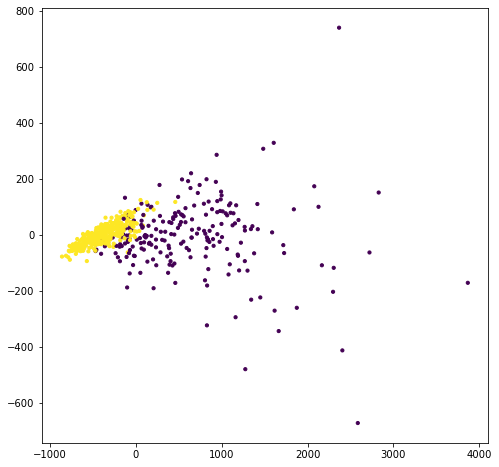

In [27]:
# Ejercicio

print(np.cumsum(pca_bc.explained_variance_ratio_))

plt.figure(figsize=(8,8))
plt.scatter(T_bc[:,0], T_bc[:,1], c=y_bc, s=10)

## ¿Afecta la escala de las variables?

### <font color='D12828'> Ejercicio: </font>

1. Obtén las dos primeras componentes principales del conjunto de datos de cancer escalado `X_bc_train`
2. Haz un scatterplot de las dos primeras componentes principales. Haz que el color cambie en función del tipo de tumor (almacenado en y_bc_train)

[0.44413492 0.6335811 ]


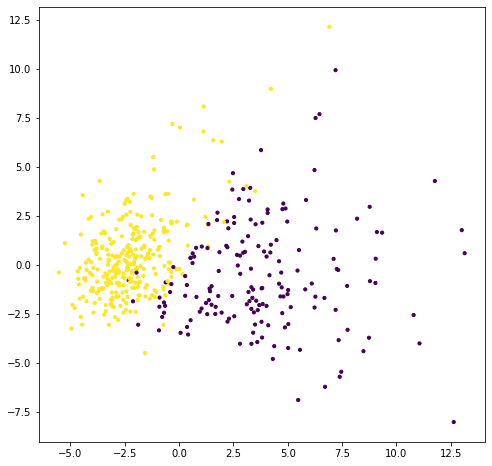

In [28]:
# Ejercicio

pca_bc = PCA(n_components=2)
T_bc = pca_bc.fit_transform(X_bc_train_s)    
print(np.cumsum(pca_bc.explained_variance_ratio_))

plt.figure(figsize=(8,8))
plt.scatter(T_bc[:,0], T_bc[:,1], c=y_bc_train, s=10)

## ¿Con cuantas componentes nos quedamos?

Si nuestra matriz de datos original $X$ tiene $n$ observaciones y $p$ variables, podremos calcular como máximo, min(n, p) componentes. Eso quiere decir que:

* Si tenemos 500 filas y 10 variables, como máximo podremos obtener __10 componentes principales__, y las 10 componentes explicarán el 100% de la variabilidad original.
* Si tenemos 100 filas y 2000 variables, como máximo podremos obtener __100 componentes principales__, que explicarán el 100% de la variabilidad original.

Observa que en problemas de __alta dimensión__, en los que el número de variables es mayor que el número de observaciones, PCA permite conseguir una __gran reducción de la dimensión__ sin ofrecer casi pérdida de información. __El coste, claro, está en la interpretabilidad de las nuevas variables__.

Por otro lado, más que un número al azar de componentes, lo habitual es elegir el número de componentes tal que nos permita explicar hasta un cierto porcentaje de la variabilidad original (lo habitual suele ser en torno al 95% pero depende de los datos). Sklearn tiene esto en cuenta, así que el parámetro `n_components` puede fijarse como un número de componentes, o, si es un número entre 0 y 1, se interpreta como un porcentaje de variabilidad a explicar. Por ejemplo, construyamos suficientes componentes para explicar el 95% de la variabilidad del conjunto de datos de iris.

In [29]:
pca_iris = PCA(n_components=0.95)

T_iris = pca_iris.fit_transform(X_iris)  # scores
P_iris = pca_iris.components_.T          # loadings

P_iris

array([[ 0.36138659,  0.65658877],
       [-0.08452251,  0.73016143],
       [ 0.85667061, -0.17337266],
       [ 0.3582892 , -0.07548102]])

### <font color='D12828'> Ejercicio: </font>

1. Obtén las componentes principales suficientes para explicar el 90% de la variabilidad del conjunto de datos de cancer estandarizado. ¿Cuantas componentes son suficientes?
2. Construye un clasificador KNN con `n_neighbors=10` que utilice estas componentes principales
3. Obtén el error de clasificación 

In [30]:
# Ejercicio

pca_bc = PCA(n_components=0.90)
T_bc = pca_bc.fit_transform(X_bc_train_s)
T_bc_test = pca_bc.transform(X_bc_test_s)

print(T_bc.shape)

knn.fit(T_bc, y_bc_train)

# Predecir en el conjunto de test
y_test_pred = knn.predict(T_bc_test)

# Error 
error = accuracy_score(y_bc_test, y_test_pred)
print(f'Accuracy: {error}')

(455, 7)
Accuracy: 0.956140350877193


### <font color='D12828'> Ejercicio: </font>
4. Repite el proceso con el conjunto de datos no estandarizado. ¿Cual da mejor resultado?

In [31]:
# Ejercicio

pca_bc = PCA(n_components=0.90)
T_bc = pca_bc.fit_transform(X_bc_train)
T_bc_test = pca_bc.transform(X_bc_test)

print(T_bc.shape)

knn.fit(T_bc, y_bc_train)

# Predecir en el conjunto de test
y_test_pred = knn.predict(T_bc_test)

# Error 
error = accuracy_score(y_bc_test, y_test_pred)
print(f'Accuracy: {error}')

(455, 1)
Accuracy: 0.9298245614035088


Geométricamente, quedarse con tantas componentes principales como el número de variables iniciales implica que el número de dimensiones, y la distancia entre las observaciones es la misma, es decir, no traería ningún cambio en los resultados de un algoritmo predictivo con respecto a usar los datos originales.

### <font color='D12828'> Ejercicio: </font>
1. En el conjunto de datos de boston estandarizado `X_boston_train_s`, construye una SVM de regresión con todas las variables y obtén el error cuadrático medio
2. Obtén tantas componentes principales como variables haya en el conjunto de datos boston estandarizado, y construye otra SVM con las componentes. Obtén el error cuadrático medio

In [32]:
# Ejercicio

svr = SVR(kernel='linear')
svr.fit(X_boston_train_s, y_boston_train)

# Predecir en el conjunto de test
y_test_pred = svr.predict(X_boston_test_s)

# Error 
error = mean_squared_error(y_boston_test, y_test_pred)
print(f'Accuracy: {error}')

Accuracy: 28.91852267161813


In [33]:
# Ejercicio

pca_boston = PCA(n_components=X_boston.shape[1])
T_boston_train = pca_boston.fit_transform(X_boston_train_s)
T_boston_test = pca_boston.transform(X_boston_test_s)

svr.fit(T_boston_train, y_boston_train)

# Predecir en el conjunto de test
y_test_pred = svr.predict(T_boston_test)

# Error 
error = mean_squared_error(y_boston_test, y_test_pred)
print(f'Accuracy: {error}')

Accuracy: 28.918522671618433


# Linear discriminant analysis

Otro tipo de proyección que ya conocereis es el linear discriminant analysis, utilizado en problemas de clasificación. La idea detrás de esta técnica es sencilla: construir unas nuevas variables en base a las originales en las que clasificar los datos sea más sencillo que con las variables originales. El número de componentes que se pueden calcular aquí es min(n_classes - 1, n_var)). Usemos esta técnica con los datos de cancer. Dado que en estos datos tenemos 30 variables pero solo 2 categorías, proyectaremos los datos en 1 dimensión.

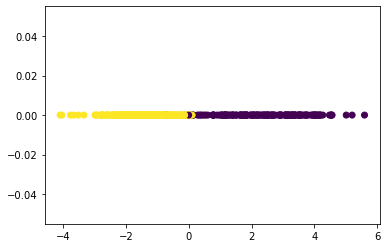

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_bc_train_lda = lda.fit_transform(X_bc_train_s, y_bc_train)

plt.scatter(X_bc_train_lda[:,0], [0]*455, c=y_bc_train)

In [35]:
# Predecir en el conjunto de test
y_test_pred = lda.predict(X_bc_test_s)

# Error 
error = accuracy_score(y_bc_test, y_test_pred)
print(f'Accuracy: {error}')

Accuracy: 0.9649122807017544


# Final
___
Con esto termina nuestra introducción a las técnicas de reducción de la dimensión, ¡espero que hayais dsifrutado!

![image.png](plots/fin_svm_2.png)
